In [1]:
import geopandas as gpd
import pandas as pd
import pygeohash as pgh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from geohashtree.geometry import *
from geohashtree.geohash_func import geohash_to_gdf,bounding_box
from geohashtree.trie import Trie

Can only import/use native python functions.


In [2]:
gdf = gpd.read_file("../../data/maryland_demo/dc_restaurants_cid.geojson")
gdf_rand_points = gpd.read_file("../../data/maryland_demo/rand_dc_point.geojson")

# Query Processor class

convert query to a list of geohashes


## Radius query
Given a central point and radius, return a list of geohashes that cover the entire query area, and has limited exceeded areas beyond query area

In [3]:
from geohashtree.geohash_func import geohashes_covering_circle, bounding_box

In [4]:
centre = (gdf_rand_points.geometry.values[0].x,gdf_rand_points.geometry.values[0].y)
centre

(-77.06817861047044, 38.99752107280757)

In [59]:
#radius (in degree for simplicity)
radius = 0.03

In [69]:
# geohash resolution for the finest part
precision = 6

# central hash
cgh = pgh.encode(latitude=centre[1], longitude=centre[0], precision=precision)
cgh

'dqcjy7'

In [70]:
result_hashes = geohashes_covering_circle(*centre,radius,precision)

In [71]:
gh_gdf = pd.concat([geohash_to_gdf(geohash) for geohash in result_hashes])


In [72]:
gdf_radius = gdf_rand_points.buffer(radius)

/var/folders/6s/50fzkjrx159f42s0rpvmm4180000gn/T/ipykernel_79015/2340457725.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_radius = gdf_rand_points.buffer(radius)


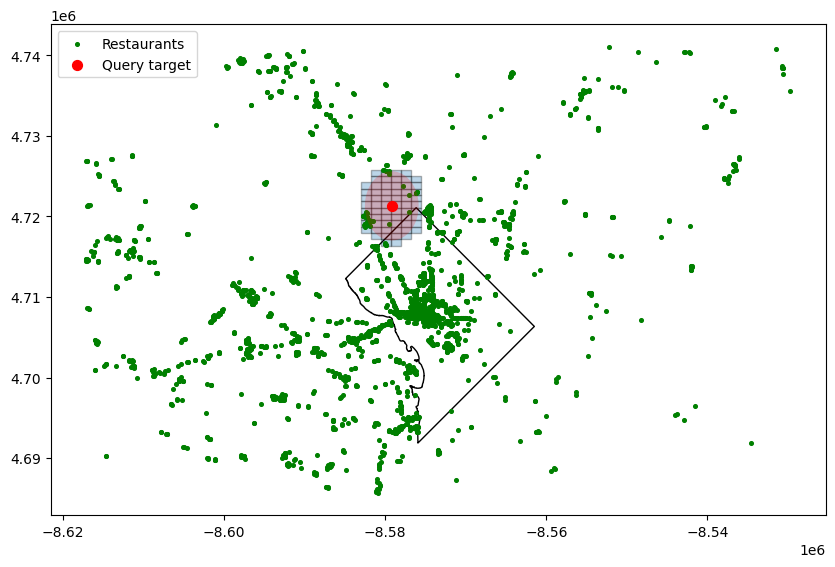

In [73]:
# Plot the bounding box and the random points
dc_outline = gpd.read_file("../../data/maryland_demo/Washington_DC_Boundary.geojson")
df_wm = gh_gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.3, edgecolor="k")
dc_outline.to_crs(epsg=3857).plot(ax=ax, facecolor='none',edgecolor="k")
gdf.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=7, label='Restaurants')
gdf_rand_points.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=50, label='Query target')
gdf_radius.to_crs(epsg=3857).plot(ax=ax,alpha=0.2,color='red')
#cx.add_basemap(ax,zoom=10)

ax.legend()
plt.show()

In [17]:
trie_dict = Trie()
# Insert each index-value pair into the Trie dictionary
for index in result_hashes:
    trie_dict.insert(index, 1)

In [97]:
def trim_full_node(node):
    if len(node.children) == 0:
        return True
    cnt = 0
    for child in node.children:
        
        cnt+=trim_full_node(node.children[child])
    if cnt == 32:
        node.children = {}
        return True
    else:
        return False

In [98]:
def trie_leaves(node,prefix_hash):
    if not node.children:
        return [prefix_hash]
    else:
        res = []
        for ch in node.children:
            res.extend(trie_leaves(node.children[ch],prefix_hash+ch))
        return res

In [99]:
def trim_hashes(input_hashes):
    trie_dict = Trie()
    # Insert each index-value pair into the Trie dictionary
    for index in result_hashes:
        trie_dict.insert(index, 1)
    trim_full_node(trie_dict.root)
    return trie_leaves(trie_dict.root,"")

In [101]:
trim_res = trim_hashes(result_hashes)

In [77]:
len(res)

25

In [104]:
trim_res

['dqcjy',
 'dqcjvg',
 'dqcjvu',
 'dqcjvf',
 'dqcjve',
 'dqcjvv',
 'dqcjvs',
 'dqcjvc',
 'dqcjvd',
 'dqcjvy',
 'dqcjvt',
 'dqcjvb',
 'dqcjv9',
 'dqcjvz',
 'dqcjvw',
 'dqcjv8',
 'dqcjwr',
 'dqcjwx',
 'dqcjwq',
 'dqcjwp',
 'dqcjwz',
 'dqcjww',
 'dqcjwm',
 'dqcjwn',
 'dqcjwj',
 'dqcjtz',
 'dqcjty',
 'dqcjtx',
 'dqcnn2',
 'dqcnn8',
 'dqcnn0',
 'dqcnjb']

In [28]:
trim_full_node(trie_dict.root)

False

In [29]:
trim_res = trie_leaves(trie_dict.root,"")

In [30]:
len(trim_res)

25

In [102]:
gh_gdf = pd.concat([geohash_to_gdf(geohash) for geohash in trim_res])


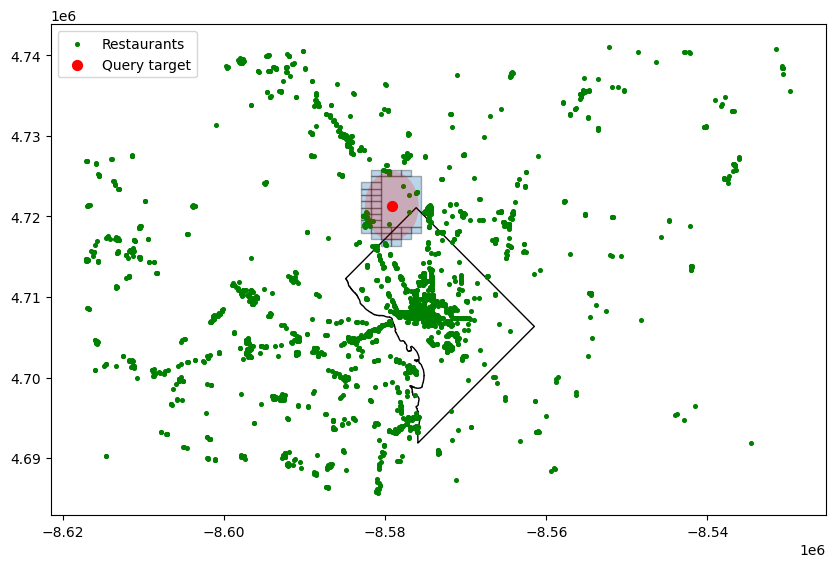

In [103]:
# Plot the bounding box and the random points
dc_outline = gpd.read_file("../../data/maryland_demo/Washington_DC_Boundary.geojson")
df_wm = gh_gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.3, edgecolor="k")
dc_outline.to_crs(epsg=3857).plot(ax=ax, facecolor='none',edgecolor="k")
gdf.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=7, label='Restaurants')
gdf_rand_points.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=50, label='Query target')
gdf_radius.to_crs(epsg=3857).plot(ax=ax,alpha=0.2,color='red')
#cx.add_basemap(ax,zoom=10)

ax.legend()
plt.show()

## k-Nearest Neighbor

In [33]:
import sys
sys.path.append("../")
from geohashtree.geohashtree import LiteTreeOffset, LiteTreeCID, FullTreeFile

In [34]:
index_path = f"../data/geohash_offset_dc_restaurants/index"

In [35]:
tree = LiteTreeOffset()

Index Mode: offline


In [36]:
hashes = ['dqcjy',
 'dqcjz',
 'dqcjw',
 'dqcjv',
 'dqcjx',
 'dqcjq',
 'dqcjt',
 'dqcju',
 'dqcjr',
 'dqcjm',
 'dqcjs',
 'dqcjg',
 'dqcjk',
 'dqcnn',
 'dqcnq',
 'dqcnp',
 'dqcnj',
 'dqcnr',
 'dqcnm',
 'dqcnh',
 'dqcnk',
 'dqcmb',
 'dqcm8',
 'dqcm2',
 'dqcq0']

In [37]:
tree = LiteTreeOffset()
tree.count(hashes,index_path)

Index Mode: offline


1279

In [ ]:
centre

In [38]:
cgh = pgh.encode(latitude=centre[1], longitude=centre[0], precision=12)


In [41]:
k = 50

In [45]:
prev = tree.count([cgh[:1]],index_path)  
scale = 0
if prev > k:
    for i in range(2,len(cgh)):
        cur = tree.count([cgh[:i]],index_path)
        if prev >= k and cur < k:
            scale = i-1
            break
        prev = cur
print(scale,cgh[:scale],cur)

4 dqcj 10


In [39]:
cgh

'dqcjy729j2bf'

1627

In [41]:
cgh = 'dqcjy'

In [10]:
tree.count(['dqcjy7'],index_path)

query_single dqcjy7


0

In [50]:
print('geohash scale to search:',cgh[:scale])

geohash scale to search: dqcj


In [51]:
#upper radius is the diagonal of parent hashgrid that has count > k
xmin, xmax,ymin,ymax = bounding_box(cgh[:scale])
r= eculidean_distance(xmin,ymin,xmax,ymax)

In [53]:
lo,hi = 0,r
mid = (lo+hi)/2
last_cnt = -1
while True:
    hashes = geohashes_covering_circle(*centre,mid,precision=6)
    valid_r = r
    cnt = 0
    for h in hashes:
        cnt+=tree.count([h],index_path)
    print(last_cnt,cnt,mid,lo,hi)
    if cnt == k:
        break
    elif cnt < k:
        lo = mid
        mid = (mid+hi)/2
    elif cnt > k:
        valid_r = min(valid_r,mid)
        hi = mid
        mid = (mid+lo)/2
    if last_cnt == cnt:
        break
    last_cnt = cnt

-1 2023 0.19652941208494246 0 0.3930588241698849
2023 921 0.09826470604247123 0 0.19652941208494246
921 198 0.049132353021235614 0 0.09826470604247123
198 38 0.024566176510617807 0 0.049132353021235614
38 144 0.03684926476592671 0.024566176510617807 0.049132353021235614
144 85 0.03070772063827226 0.024566176510617807 0.03684926476592671
85 78 0.027636948574445035 0.024566176510617807 0.03070772063827226
78 78 0.02610156254253142 0.024566176510617807 0.027636948574445035


In [54]:
valid_r

0.02610156254253142

In [55]:
cnt

78

In [57]:
result_hashes = geohashes_covering_circle(*centre,valid_r,precision=6)
cnt =sum([tree.count([h],index_path) for h in hashes])
print(cnt,hashes)

78 ['dqcjy7', 'dqcjyk', 'dqcjye', 'dqcjy6', 'dqcjy5', 'dqcjym', 'dqcjys', 'dqcjyh', 'dqcjyg', 'dqcjyd', 'dqcjy3', 'dqcjy4', 'dqcjvg', 'dqcjyq', 'dqcjyt', 'dqcjyj', 'dqcjyu', 'dqcjvu', 'dqcjyf', 'dqcjy9', 'dqcjy2', 'dqcjy1', 'dqcjvf', 'dqcjve', 'dqcjyr', 'dqcjyw', 'dqcjyn', 'dqcjyv', 'dqcjvv', 'dqcjvs', 'dqcjyc', 'dqcjy8', 'dqcjwr', 'dqcjy0', 'dqcjvc', 'dqcjvd', 'dqcnn2', 'dqcjyx', 'dqcjyp', 'dqcjyy', 'dqcjvy', 'dqcjvt', 'dqcjyb', 'dqcjwx', 'dqcjwq', 'dqcjwp', 'dqcjvb', 'dqcjv9', 'dqcnn0', 'dqcjvz', 'dqcjww', 'dqcjwn', 'dqcjtz', 'dqcjv8']


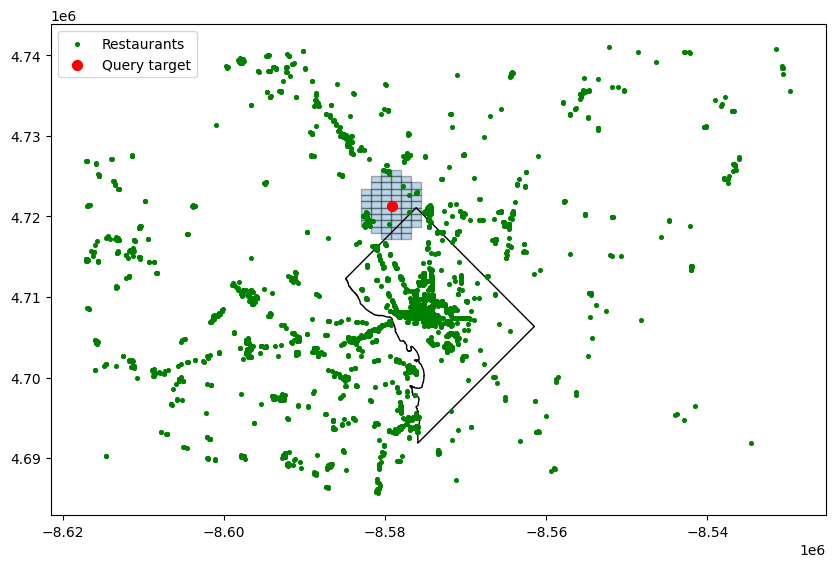

In [58]:
gh_gdf = pd.concat([geohash_to_gdf(geohash) for geohash in result_hashes])

dc_outline = gpd.read_file("../../data/maryland_demo/Washington_DC_Boundary.geojson")
df_wm = gh_gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.3, edgecolor="k")
dc_outline.to_crs(epsg=3857).plot(ax=ax, facecolor='none',edgecolor="k")
gdf.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=7, label='Restaurants')
gdf_rand_points.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=50, label='Query target')
#cx.add_basemap(ax,zoom=10)

ax.legend()
plt.show()

In [67]:
tree.query(hashes,index_path)

{'bafybeia7jlkyzt22qgh66felldr322l5c7jdvm4xspr222f4usnd2ttbze': ['(5682055, 4002)',
  '(187632, 3972)',
  '(8282562, 4013)',
  '(9624123, 4053)',
  '(4367780, 3986)',
  '(2432335, 3981)',
  '(9899742, 4027)',
  '(7047788, 3943)',
  '(2412514, 3986)',
  '(10329564, 3952)',
  '(2452216, 4004)',
  '(5686057, 3985)',
  '(4919745, 3988)',
  '(6816189, 3993)',
  '(7526321, 4023)',
  '(2436316, 3952)',
  '(4235738, 4010)',
  '(5702013, 3995)',
  '(9446882, 3952)',
  '(6788313, 3966)',
  '(10043124, 3925)',
  '(2440268, 3993)',
  '(7894126, 4001)',
  '(3648432, 3990)',
  '(2448289, 3927)',
  '(3857180, 3990)',
  '(6501522, 4038)',
  '(2392689, 3945)',
  '(2400630, 3951)',
  '(2404581, 3965)',
  '(7506584, 3949)',
  '(2420462, 3956)',
  '(8342682, 4025)',
  '(7478573, 3931)',
  '(2946205, 3982)',
  '(7797476, 4102)',
  '(6996311, 3970)',
  '(0, 157)',
  '(2428381, 3954)',
  '(4734973, 3938)',
  '(5694022, 3992)',
  '(4471762, 3941)',
  '(10333516, 3934)',
  '(6210064, 3984)',
  '(7890084, 4042)

## Bounding box query

In [3]:

from geohashtree.geohash_func import geohashes_covering_rectangle, bounding_box_to_gdf

In [4]:
centre = (-77.06817861047044, 38.99752107280757)

In [26]:
dx,dy = 0.06,0.04

In [27]:
bbox = centre[0]-dx,centre[0]+dx,centre[1]-dy,centre[1]+dy

In [28]:
bbox

(-77.12817861047044, -77.00817861047044, 38.95752107280757, 39.03752107280757)

In [29]:
result_hashes = geohashes_covering_rectangle(*bbox,precision=6)

In [30]:
bbox_df = bounding_box_to_gdf(*bbox)

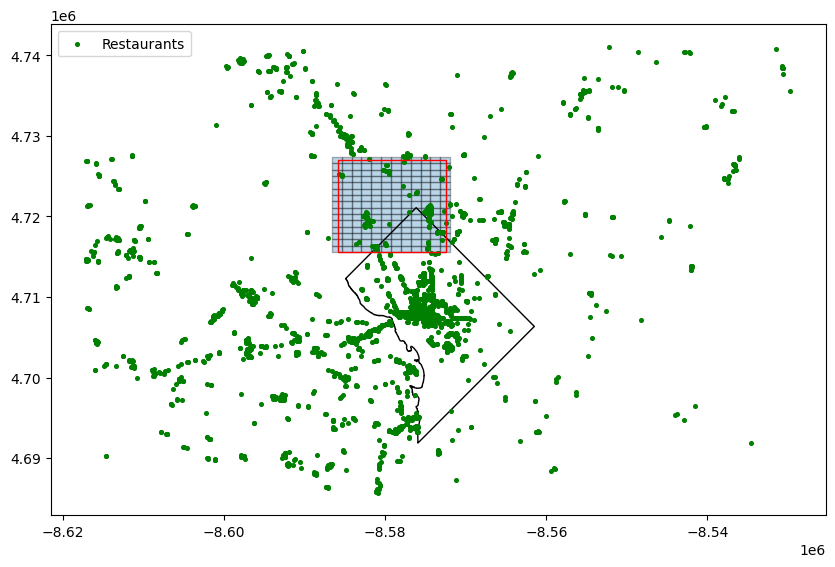

In [32]:
gh_gdf = pd.concat([geohash_to_gdf(geohash) for geohash in result_hashes])

dc_outline = gpd.read_file("../../data/maryland_demo/Washington_DC_Boundary.geojson")
df_wm = gh_gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.3, edgecolor="k")
dc_outline.to_crs(epsg=3857).plot(ax=ax, facecolor='none',edgecolor="k")
gdf.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=7, label='Restaurants')
bbox_df.to_crs(epsg=3857).plot(ax=ax,facecolor='none', edgecolor='red', legend='Query bbox')
#cx.add_basemap(ax,zoom=10)

ax.legend()
plt.show()